Task3 : Controlable Niose Map Observation

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, shapiro, levene
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


ModuleNotFoundError: No module named 'matplotlib'

Data summary

In [24]:
# Load the data (assuming the dataframes real_df and syn_df are available)
real_df = pd.read_csv('../results/stage2/Task4/3/results-3-real.csv')
syn_df = pd.read_csv('../results/stage2/Task4/3/results-3-syn.csv')

# Merging the real and synthetic DataFrames for analysis
merged_df = pd.merge(real_df, syn_df, on=['Image_Index', 'Noise_level'], suffixes=('_real', '_syn'))

# Preview the first few rows
print(merged_df.head())

   Image_Index Noise_level  PSNR_real  SSIM_real  LPIPS_real  BRISQUE_real  \
0            0        high  25.225878   0.946783    0.488028     70.194275   
1            0         mid  19.281309   0.897228    0.608931     34.169128   
2            0         low  22.272856   0.948090    0.220972     92.234436   
3            1        high  25.290358   0.950145    0.503042     72.713806   
4            1         mid  19.486982   0.946562    0.172984    100.452026   

   MUSIQ_real  NIMA_real  NIQE_real   PSNR_syn  SSIM_syn  LPIPS_syn  \
0   22.131226   2.514439  11.259880  23.965740  0.948646   0.420798   
1   36.558865   3.214453   9.360005  19.586870  0.921490   0.185342   
2   19.665245   3.316759  20.543077  18.657621  0.759324   0.638172   
3   22.784182   2.526016  10.941504  24.383865  0.950526   0.388705   
4   31.480690   3.035587  26.171356  19.519091  0.921870   0.236295   

   BRISQUE_syn  MUSIQ_syn  NIMA_syn   NIQE_syn  
0    70.070496  25.272955  2.898843  13.206671  
1   10

Histogram Visualization

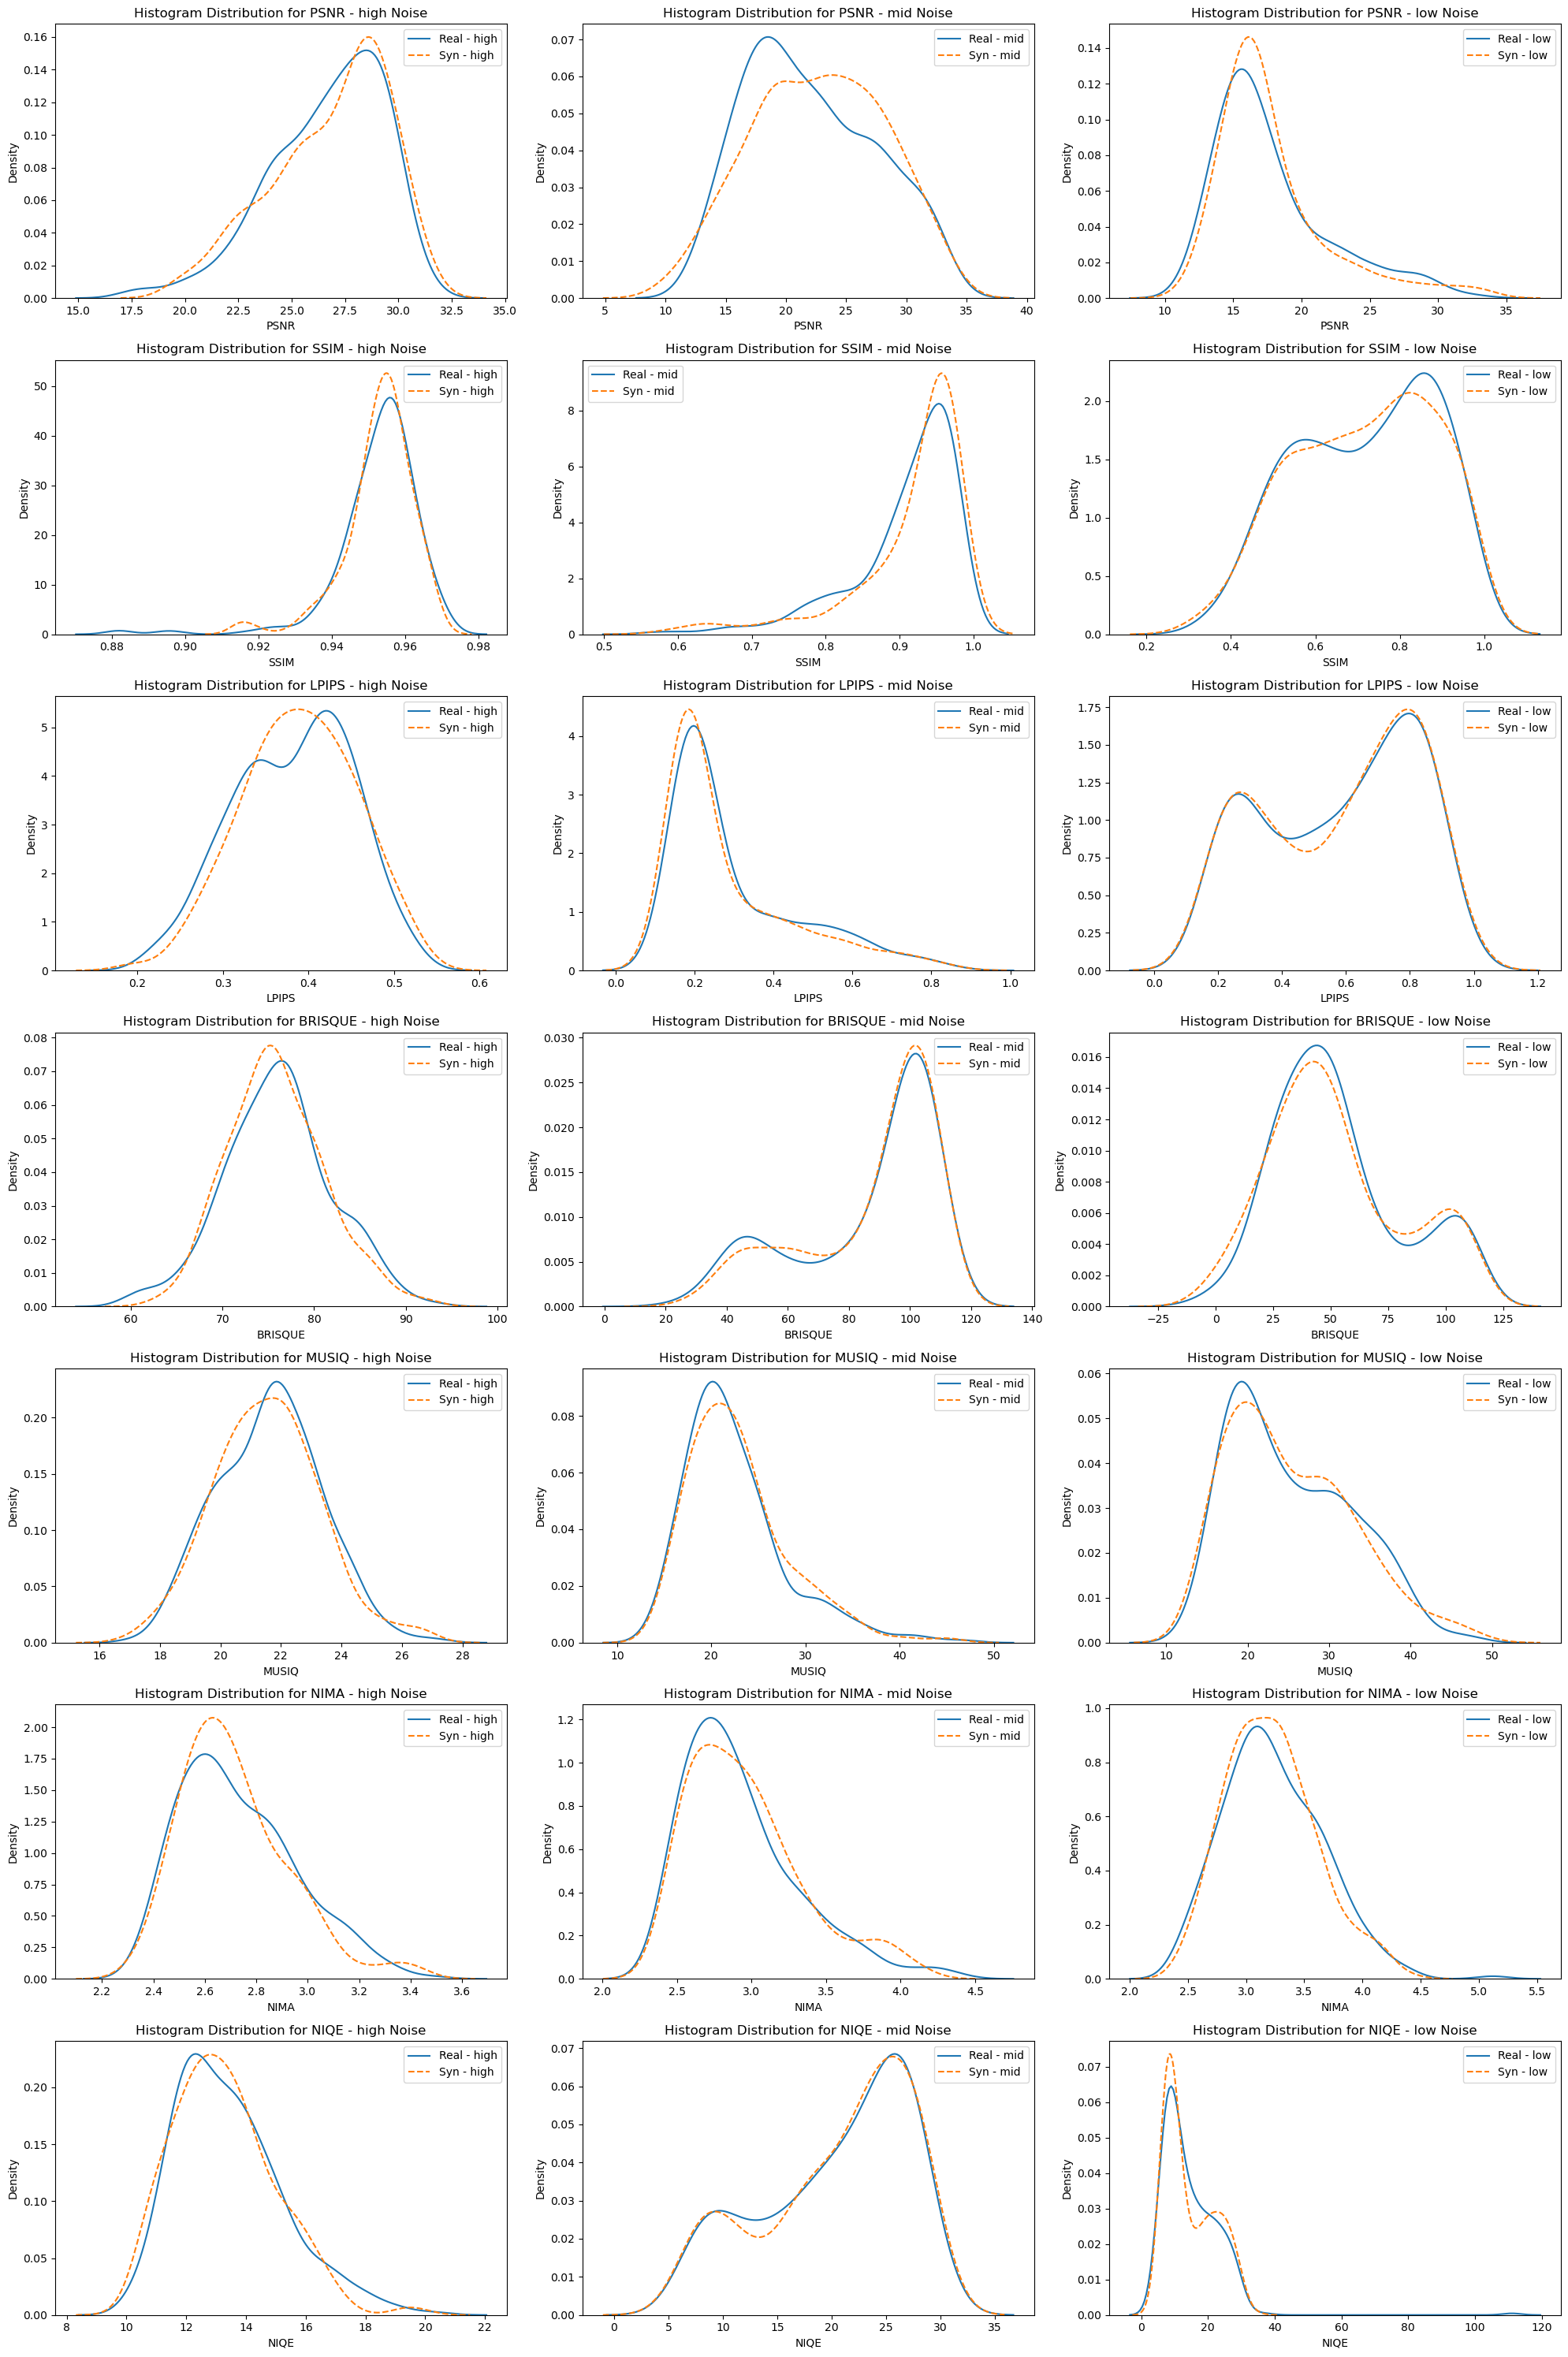

In [27]:
# Metrics to visualize
metrics = ['PSNR', 'SSIM', 'LPIPS', 'BRISQUE', 'MUSIQ', 'NIMA', 'NIQE']

# 1. Histogram Distribution for Each Metric by Noise Level
plt.figure(figsize=(20, 30))
for idx, metric in enumerate(metrics):
    for noise_level in ['high', 'mid', 'low']:
        plt.subplot(len(metrics), 3, idx * 3 + ['high', 'mid', 'low'].index(noise_level) + 1)
        sns.kdeplot(real_df[real_df['Noise_level'] == noise_level][metric], label=f'Real - {noise_level}', linestyle='-')
        sns.kdeplot(syn_df[syn_df['Noise_level'] == noise_level][metric], label=f'Syn - {noise_level}', linestyle='--')
        plt.title(f'Histogram Distribution for {metric} - {noise_level} Noise')
        plt.xlabel(metric)
        plt.ylabel('Density')
        plt.legend()
plt.tight_layout()
plt.show()

Statistical Analyse

1 - Bar Plots 

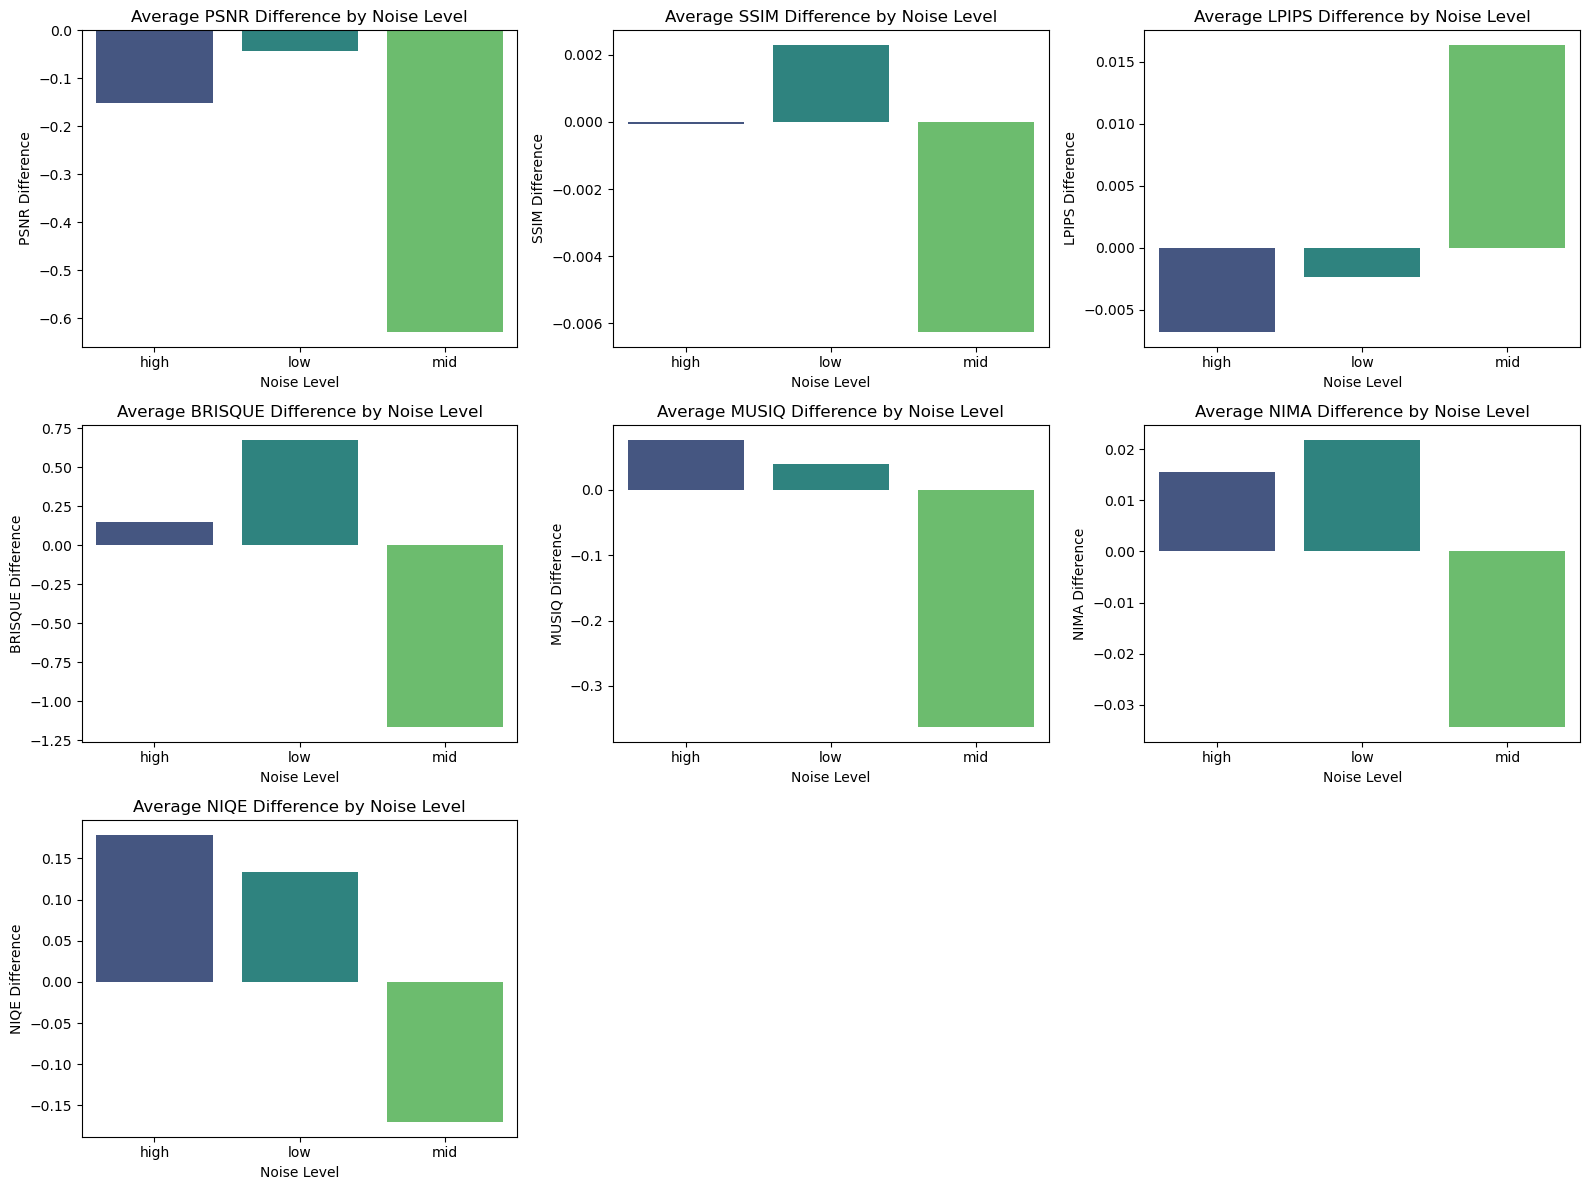

In [28]:
# 2. Bar Plots for Average Differences by Noise Level
# Calculating differences
for metric in metrics:
    merged_df[f'{metric}_diff'] = merged_df[f'{metric}_real'] - merged_df[f'{metric}_syn']
noise_level_diff_summary = merged_df.groupby('Noise_level')[[f'{metric}_diff' for metric in metrics]].mean()

plt.figure(figsize=(16, 12))
for idx, metric in enumerate(metrics):
    plt.subplot(3, 3, idx + 1)
    sns.barplot(x=noise_level_diff_summary.index, y=noise_level_diff_summary[f'{metric}_diff'], palette='viridis')
    plt.title(f'Average {metric} Difference by Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel(f'{metric} Difference')
plt.tight_layout()
plt.show()

3 - Box Plots

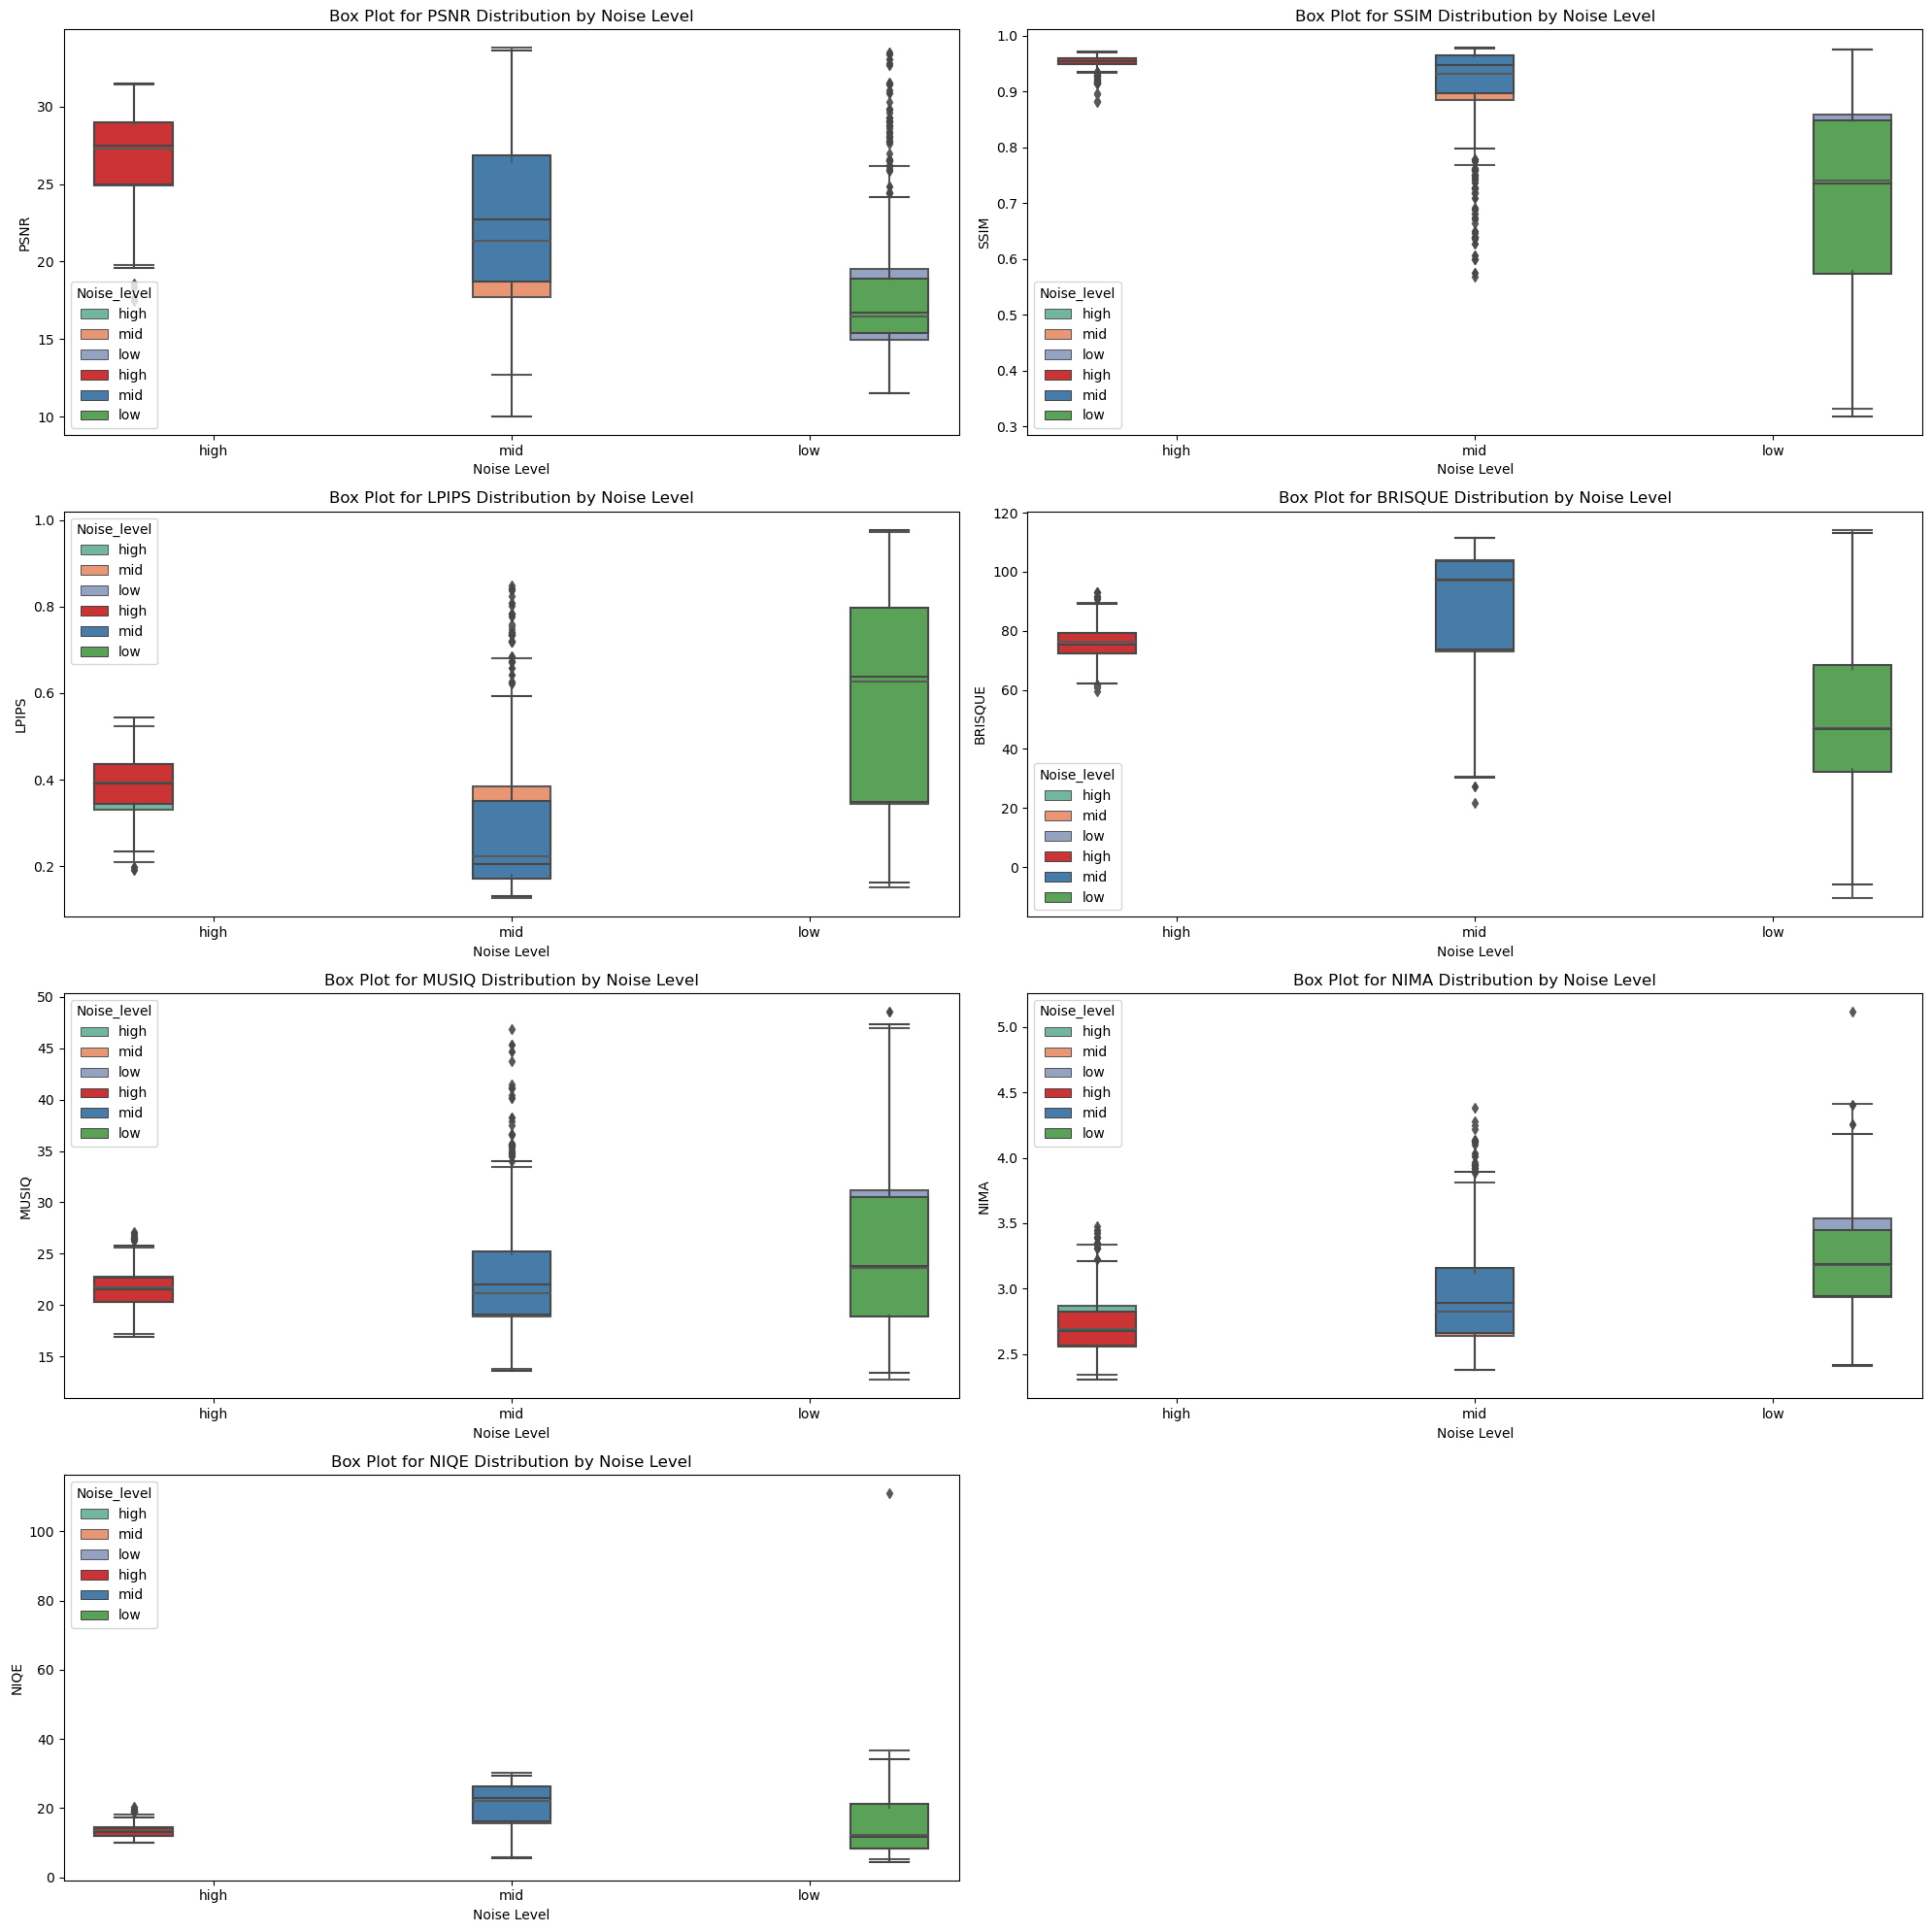

In [31]:
# 3. Box Plots to Show Metric Distributions
plt.figure(figsize=(20, 20))
for idx, metric in enumerate(metrics):
    plt.subplot(4, 2, idx + 1)
    sns.boxplot(x='Noise_level', y=metric, hue='Noise_level', data=real_df, palette='Set2', dodge=True)
    sns.boxplot(x='Noise_level', y=metric, hue='Noise_level', data=syn_df, palette='Set1', dodge=True)
    plt.title(f'Box Plot for {metric} Distribution by Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

4 - Hypothesis Testing

In [ ]:
for idx, metric in enumerate(metrics):
    print(f"{metric}:")
    for noise_level in ['high', 'mid', 'low']:

        real_data = real_df[real_df['Noise Level'] == noise_level][metric]
        syn_data = syn_df[syn_df['Noise Level'] == noise_level][metric]

        # Normality Test - Shapiro-Wilk
        shapiro_syn = shapiro(real_data)
        shapiro_real = shapiro(syn_data)
        print(f"Shapiro Test for Real {metric} - {noise_level} noise - p-value: {shapiro_real.pvalue}")
        print(f"Shapiro Test for Synthetic {metric} - {noise_level} noise - p-value: {shapiro_syn.pvalue}")
        print("--------------------------------------------------------------------------------")

        # Variance Homogeneity Test - Levene's Test
        levene_test = levene(syn_data, real_data)
        print(f"Levene's Test for Equal Variance {metric} - {noise_level} noise - p-value: {levene_test.pvalue}")
        print("--------------------------------------------------------------------------------")

        # If data is normal and variances are equal, use t-test
        if shapiro_syn.pvalue > 0.05 and shapiro_real.pvalue > 0.05 and levene_test.pvalue > 0.05:
            t_stat, t_pvalue = ttest_ind(syn_data, real_data)
            print(f"T-Test - t-statistic: {t_stat}, p-value: {t_pvalue}")
            print("--------------------------------------------------------------------------------")

            # Analysis: The t-test checks if there is a significant difference in means between the two groups.
            # Expectation: If p-value < 0.05, it suggests that the means of the synthetic and real PSNR values are significantly different.
        else:
            # If data is not normal, use Mann-Whitney U Test
            u_stat, u_pvalue = mannwhitneyu(syn_data, real_data)
            print(f"Mann-Whitney U Test - u-statistic: {u_stat}, p-value: {u_pvalue}")
            print("--------------------------------------------------------------------------------")


        # Kolmogorov-Smirnov Test
        ks_stat, ks_pvalue = ks_2samp(syn_data, real_data)
        print(f"Kolmogorov-Smirnov Test - ks-statistic: {ks_stat}, p-value: {ks_pvalue}")
        print("--------------------------------------------------------------------------------")

        print()

    print()


PSNR:
Shapiro Test for Real PSNR - hight noise - p-value: 3.298567911949111e-10
Shapiro Test for Synthetic PSNR - hight noise - p-value: 6.447524292211874e-06
--------------------------------------------------------------------------------
Levene's Test for Equal Variance PSNR - hight noise - p-value: 0.9573132411376546
--------------------------------------------------------------------------------
Mann-Whitney U Test - u-statistic: 47162.5, p-value: 0.3085219405801942
--------------------------------------------------------------------------------
Kolmogorov-Smirnov Test - ks-statistic: 0.08, p-value: 0.2926468667924955
--------------------------------------------------------------------------------

Shapiro Test for Real PSNR - mid noise - p-value: 0.0004251505243930697
Shapiro Test for Synthetic PSNR - mid noise - p-value: 0.00018292035695365003
--------------------------------------------------------------------------------
Levene's Test for Equal Variance PSNR - mid noise - p-val

5 - Effect Size (Cohen's d)

In [24]:
# Step 4: Effect Size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std


for idx, metric in enumerate(metrics):
    print(f"{metric}:")
    for noise_level in ['hight', 'mid', 'low']:

        real_data = real_df[real_df['Noise Level'] == noise_level][metric]
        syn_data = syn_df[syn_df['Noise Level'] == noise_level][metric]

        d = cohens_d(syn_data, real_data)
        print(f"Cohen's d - {noise_level} noise: {d}")

    print()

PSNR:
Cohen's d - hight noise: 0.047051769714420676
Cohen's d - mid noise: 0.1451020723113047
Cohen's d - low noise: 0.06616309242439976

SSIM:
Cohen's d - hight noise: -0.029162202046818717
Cohen's d - mid noise: 0.1721584702599087
Cohen's d - low noise: -0.036562897809226017

LPIPS:
Cohen's d - hight noise: 0.09676422348197196
Cohen's d - mid noise: -0.16895554867019347
Cohen's d - low noise: 0.06647507731602827

BRISQUE:
Cohen's d - hight noise: -0.06513532646026715
Cohen's d - mid noise: 0.11325953767843491
Cohen's d - low noise: -0.10504942303665775

MUSIQ:
Cohen's d - hight noise: -0.02109015804478087
Cohen's d - mid noise: 0.07966779598643015
Cohen's d - low noise: 0.007572965877619396

NIMA:
Cohen's d - hight noise: -0.0754243918032218
Cohen's d - mid noise: 0.04374444400663136
Cohen's d - low noise: -0.1107029801287088

NIQE:
Cohen's d - hight noise: -0.11255744465110244
Cohen's d - mid noise: 0.07065598679072004
Cohen's d - low noise: -0.08615358107589378



6 - ROC Curve Analysis

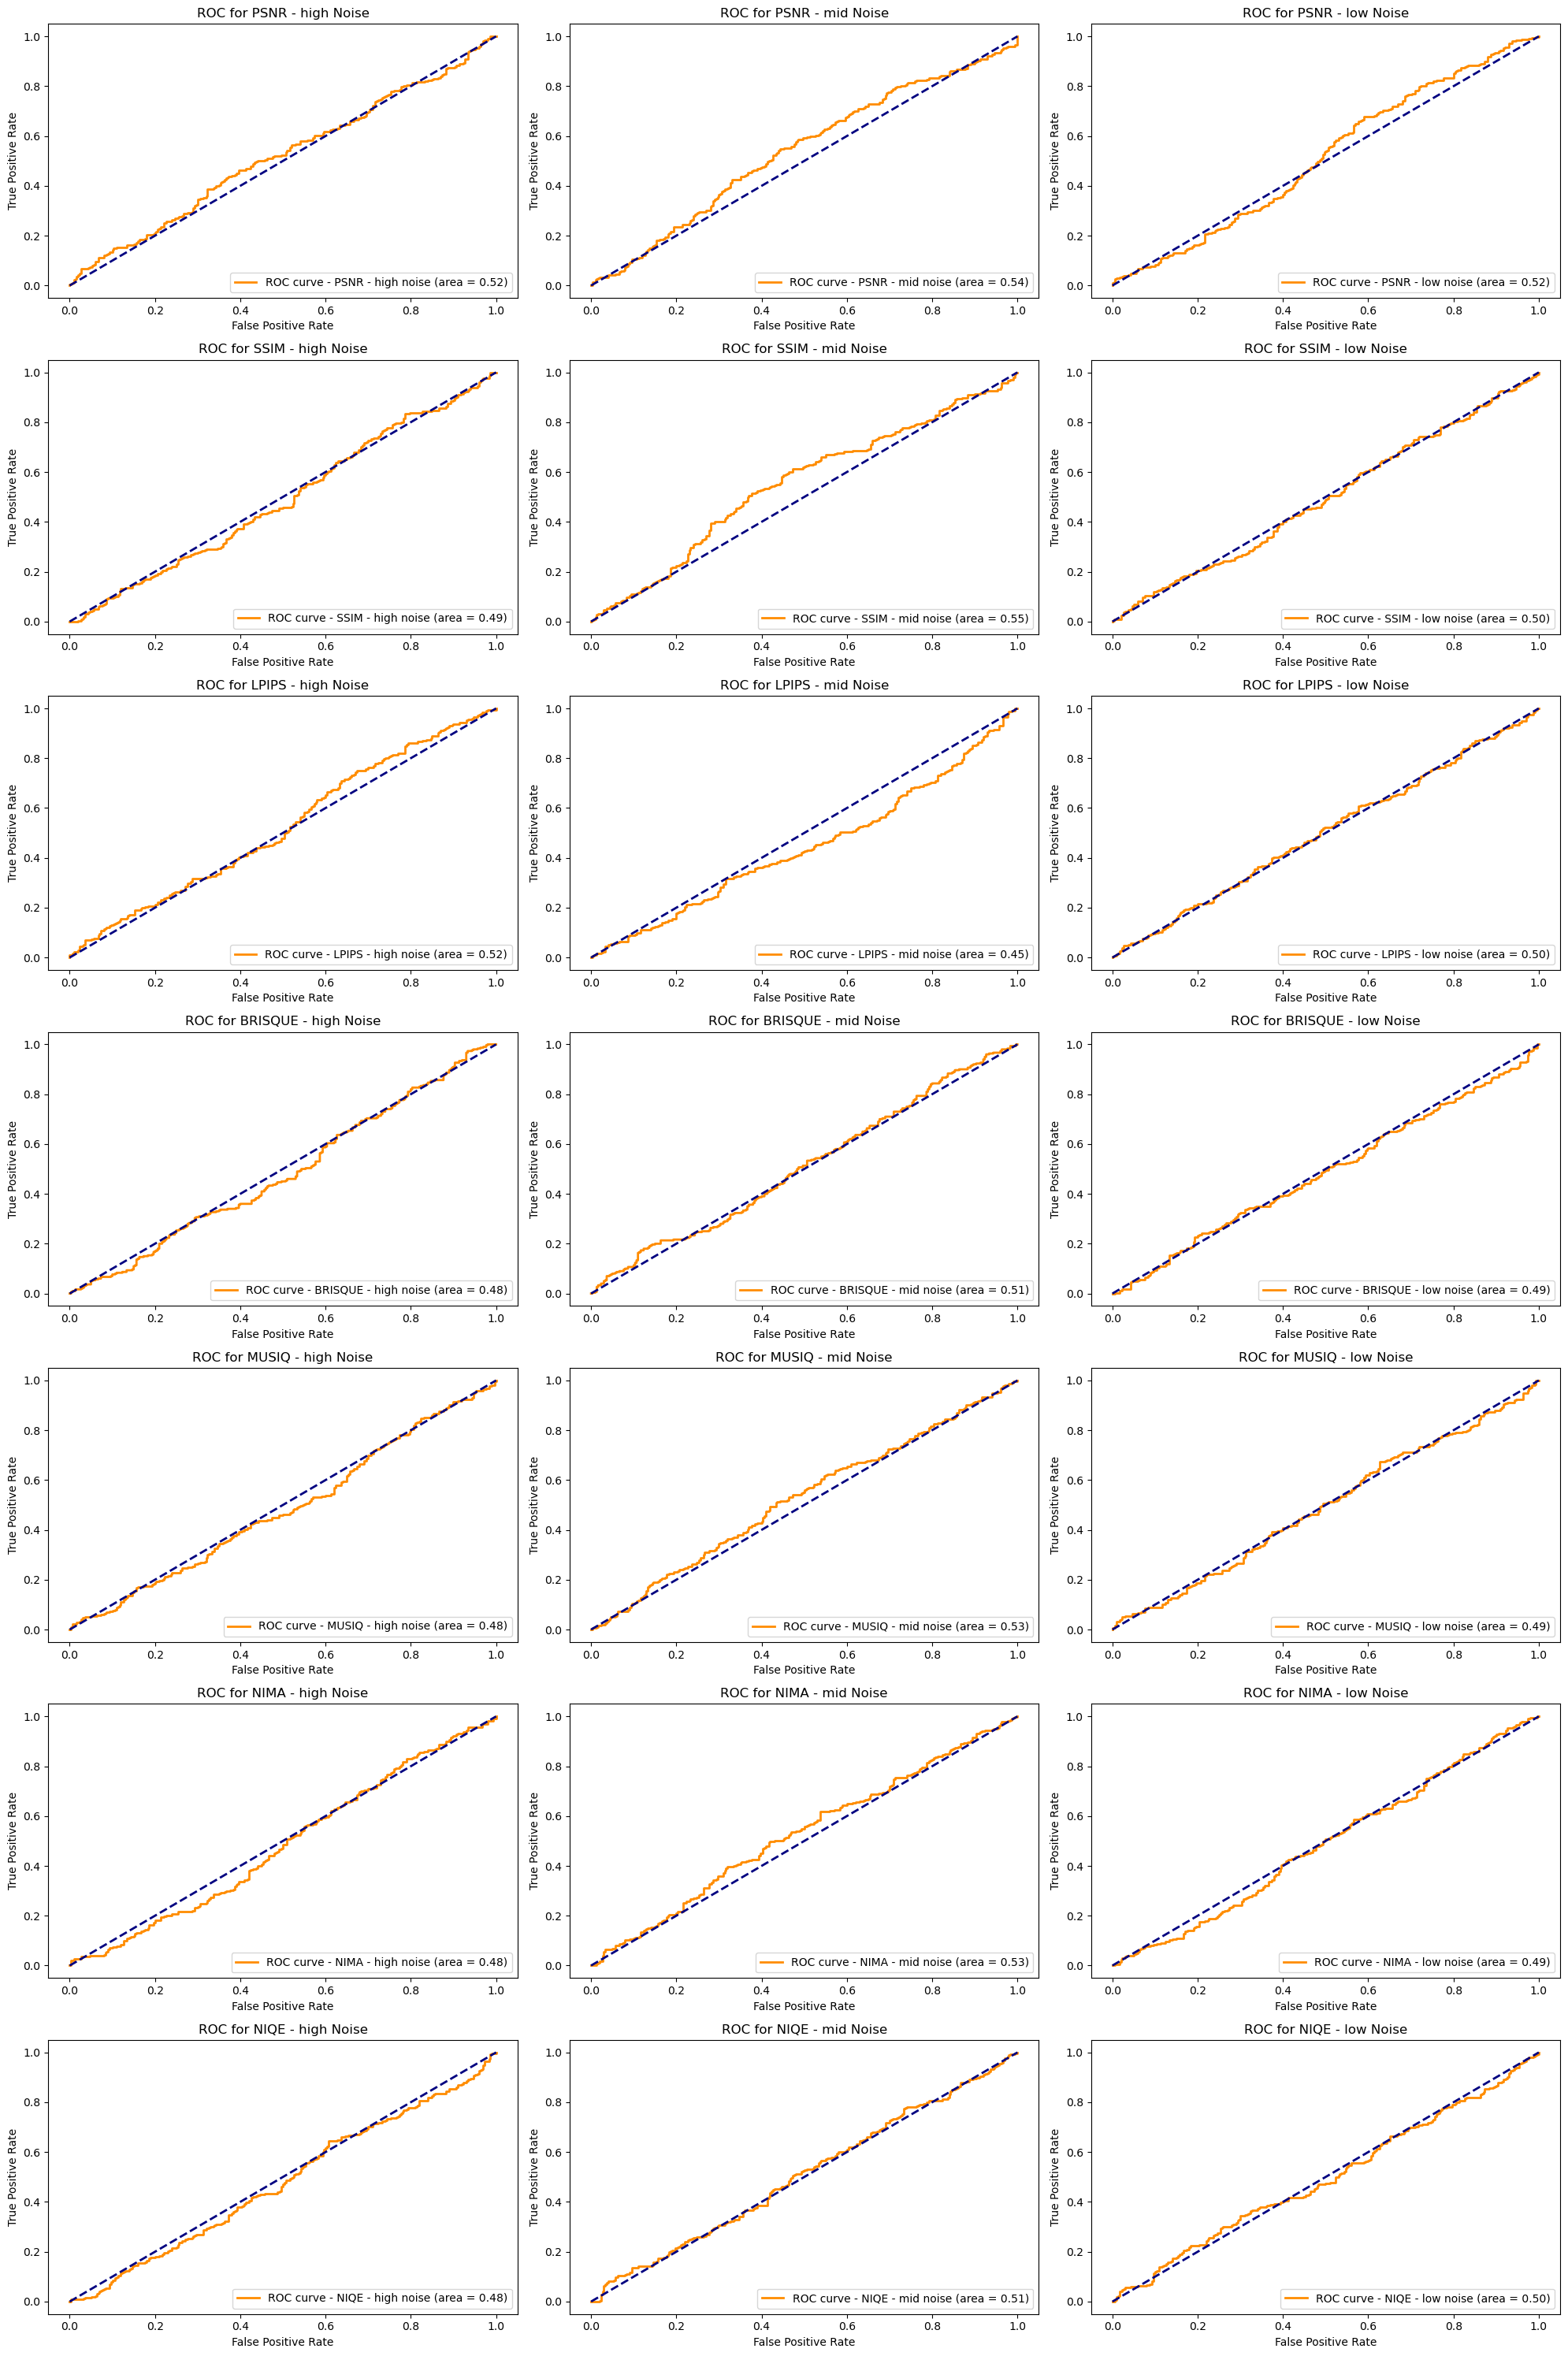

In [32]:
plt.figure(figsize=(20, 30))

for idx, metric in enumerate(metrics):
    for noise_level in ['high', 'mid', 'low']:

        real_data = real_df[real_df['Noise_level'] == noise_level][metric]
        syn_data = syn_df[syn_df['Noise_level'] == noise_level][metric]

        psnr_values = np.concatenate((real_data, syn_data))
        labels = np.array([0] * len(real_data) + [1] * len(syn_data))  # 0 for real, 1 for synthetic

        # Plotting the ROC curve
        fpr, tpr, thresholds = roc_curve(labels, psnr_values)
        roc_auc = auc(fpr, tpr)

        plt.subplot(len(metrics), 3, idx * 3 + ['high', 'mid', 'low'].index(noise_level) + 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve - {metric} - {noise_level} noise (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title(f'ROC for {metric} - {noise_level} Noise')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
